### Kütüphanelerin Tanımlanması

In [77]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np

### Fonksiyonların Tanımlanması

In [78]:
def resmi_goster(image, title,  cmap="gray"):
    
  plt.title(title)
  plt.imshow(image, cmap=cmap)
  plt.axis('off')
  plt.show()

    
def dilation(image, kernel_size, iterations, kernel="np"):
    
    if kernel == "np":
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
    elif kernel == "cv2":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    dilated_img = cv2.dilate(image, kernel, iterations=iterations)
    return dilated_img



def erosion(image, kernel_size, iterations, kernel="np"):
    
    if kernel == "np":
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
    elif kernel == "cv2":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    eroded_img = cv2.erode(image, kernel, iterations=iterations)
    return eroded_img



### Görüntünün Alınması

In [79]:
path = "./hucre.png"

img = cv2.imread(path, 0)

### Görüntüyü Göster

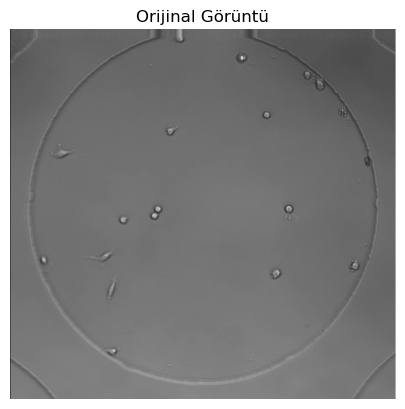

In [80]:
resmi_goster(img, "Orijinal Görüntü")

### Görüntüye Yumuşatma (Smoothing) Uygulanması

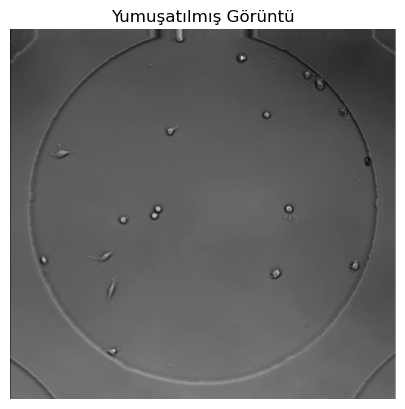

In [81]:
smooth_img = cv2.GaussianBlur(img, (5,5), 0)
resmi_goster(smooth_img, "Yumuşatılmış Görüntü")

### 1) Verilen Görüntüye Keskinleştirme Uygulayınız.

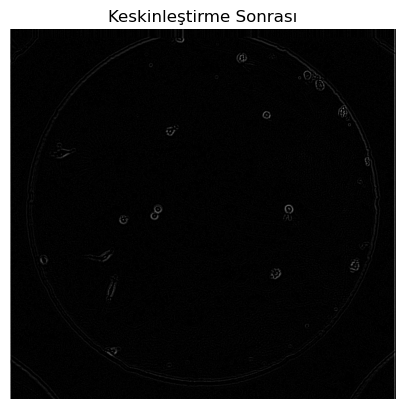

In [82]:
laplace_full = cv2.Laplacian(smooth_img, cv2.CV_8U,3,3,2)
laplace_img = cv2.convertScaleAbs(laplace_full)

resmi_goster(laplace_img, "Keskinleştirme Sonrası")

### 2) Elde Edilen Görüntüye En Uygun Eşikleme Yöntemini Uygulayarak İkili Görüntüye Dönüştürün.

Threshold Değeri:  64.0


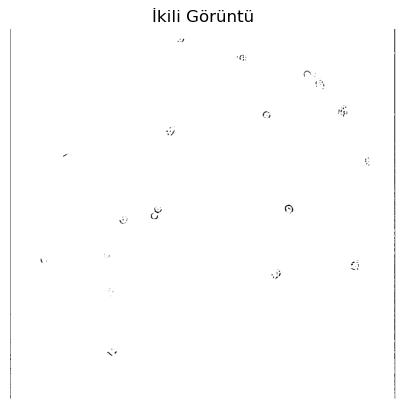

In [83]:
ret, binary_image = cv2.threshold(laplace_img, 0, 255, cv2.THRESH_BINARY_INV +  cv2.THRESH_OTSU)

print("Threshold Değeri: ", ret)

resmi_goster(binary_image, "İkili Görüntü")

### 3) Morfolojik Teknik Uygulama

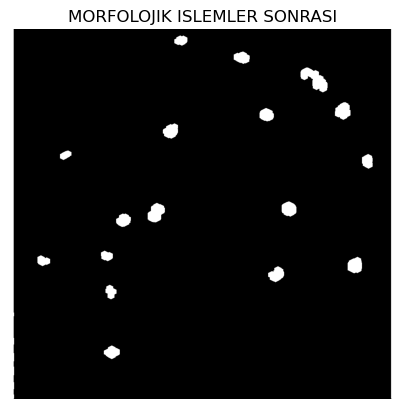

In [84]:
#There should be at least 5 points to fit the ellipse in function 'cv::fitEllipseNoDirect' hatasının giderilmesi
# iterasyon sayısı arttırılmalı. Böylelikle boşluk olan alanlar birleşir ve bir elipse oluşturulabilir.
morf_img = erosion(binary_image, kernel_size=5, iterations=4, kernel="cv2")
#morf_img = perform_dilation(morf_img, kernel_size=3, iterations=1)

morf_img = cv2.bitwise_not(morf_img)

resmi_goster(morf_img, "MORFOLOJIK ISLEMLER SONRASI")

### 4) CCL Algoritmasının Uygulanması

In [85]:
nb_components, comp, stats, centroids = cv2.connectedComponentsWithStats( morf_img, connectivity=8)
sizes = stats[1:, -1]; 
nb_components = nb_components - 1
print("nb_components: ", nb_components)

nb_components:  19


### 5) Bileşenleri Farklı Renklerle Görüntüleyerek Sonuçları Gösteriniz.

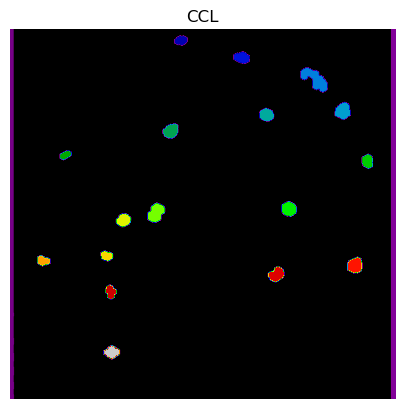

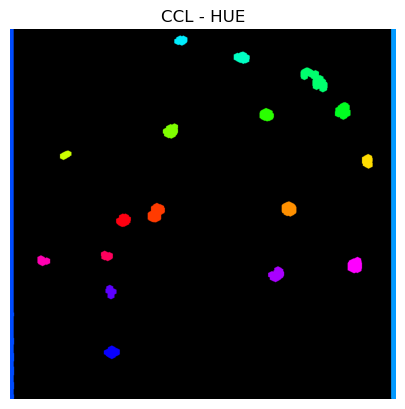

In [86]:
# Normal gösterim
resmi_goster(comp, title="CCL" ,cmap="nipy_spectral")


# Hue Gösterimi (Araştırmalar sonucunda görülmüş ve denenmek istenmiştir!)
label_hue = np.uint8(179*comp/np.max(comp))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# RGB ye çevir
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# Arkaplanı siyah yap
labeled_img[label_hue==0] = 0

resmi_goster(labeled_img, "CCL - HUE")

### 6) İlgili Her Bölge/Nesne İçin Alanı, Yönü ve Daireselliği (Area, Orientation, Circularity) Hesaplayınız.

In [87]:
area=np.zeros(nb_components)  
perimeter=np.zeros(nb_components, dtype=int) 
circularity=np.zeros(nb_components) 
orientation=np.zeros(nb_components) 


for i in range(0, nb_components):
    
    img2 = np.zeros((comp.shape),dtype = np.uint8)
    img2[comp == i ] = 255

    contours,hierarchy = cv2.findContours(img2, 1, 2)
    cnt = contours[0]
    
    #num_points = len(cnt)
    #print(f"Kontürdeki Nokta Sayısı: {num_points}")
    
   
    # Alan
    area[i] = cv2.contourArea(cnt)
    
    # Çevre
    perimeter[i] = cv2.arcLength(cnt,True)
   
    # Dairesellik (Circularity)
    circularity[i] = (4 * np.pi * area[i]) / (perimeter[i] ** 2)
   

    (x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
    orientation[i] = angle
    
    print("{0} . bileşen için alan: {1}, dairesellik: {2}, yön: {3}".format(i + 1, area[i], circularity[i], orientation[i]))


1 . bileşen için alan: 909.0, dairesellik: 0.7550288114516814, yön: 81.82292175292969
2 . bileşen için alan: 7309.0, dairesellik: 0.02760693278831924, yön: 179.9959716796875
3 . bileşen için alan: 9921.5, dairesellik: 0.037433588605851616, yön: 179.9678497314453
4 . bileşen için alan: 552.0, dairesellik: 0.7372341990781447, yön: 81.28630065917969
5 . bileşen için alan: 808.5, dairesellik: 0.7296689630644493, yön: 99.63298797607422
6 . bileşen için alan: 1971.5, dairesellik: 0.4265525673836385, yön: 128.3972930908203
7 . bileşen için alan: 1139.0, dairesellik: 0.740805141025573, yön: 29.277008056640625
8 . bileşen için alan: 823.0, dairesellik: 0.8244677148929846, yön: 100.81964874267578
9 . bileşen için alan: 963.5, dairesellik: 0.7506787827475394, yön: 53.91427230834961
10 . bileşen için alan: 399.5, dairesellik: 0.6948463751469189, yön: 64.26225280761719
11 . bileşen için alan: 691.0, dairesellik: 0.8028256374373325, yön: 172.9839630126953
12 . bileşen için alan: 986.0, dairesellik: 

### 7) Her Bölgenin Sınır Piksellerini Tanımlayın (Edge Detection). Alanın Çevreye Oranını, Kompaktlığı (Compactness, the ratio of the area to the perimeter) Hesaplayın

In [88]:
alan = np.zeros(nb_components)
cevre = np.zeros(nb_components)
kompaktlik = np.zeros(nb_components)

ccl_edges = []

for i in range(0, nb_components):
   
    # Region of Interest
    component_roi = np.uint8(comp == i) * 255

    # Canny Edge Detection
    edges = cv2.Canny(component_roi, 50, 150)
    
    ccl_edges.append(edges)
    #resmi_goster(edges, "EDGES")

    # Alan
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    alan[i] = cv2.contourArea(contours[0])

    # Çevre
    cevre[i] = cv2.arcLength(contours[0], closed=True)

    # Kompaktlık
    kompaktlik[i] = alan[i] / cevre[i]

    print("{0}.bileşen için alan: {1:,.3f}, çevre: {2:,.3f}, kompaktlık: {3:,.3f}".format(i + 1, alan[i], cevre[i], kompaktlik[i]))

1.bileşen için alan: 6.500, çevre: 233.037, kompaktlık: 0.028
2.bileşen için alan: 0.000, çevre: 1,813.113, kompaktlık: 0.000
3.bileşen için alan: 0.000, çevre: 1,804.828, kompaktlık: 0.000
4.bileşen için alan: 593.000, çevre: 97.255, kompaktlık: 6.097
5.bileşen için alan: 858.500, çevre: 117.497, kompaktlık: 7.307
6.bileşen için alan: 2,084.500, çevre: 236.066, kompaktlık: 8.830
7.bileşen için alan: 1,199.500, çevre: 138.811, kompaktlık: 8.641
8.bileşen için alan: 872.000, çevre: 114.912, kompaktlık: 7.588
9.bileşen için alan: 1,018.500, çevre: 125.983, kompaktlık: 8.084
10.bileşen için alan: 437.000, çevre: 84.426, kompaktlık: 5.176
11.bileşen için alan: 736.000, çevre: 105.598, kompaktlık: 6.970
12.bileşen için alan: 1,043.500, çevre: 123.983, kompaktlık: 8.416
13.bileşen için alan: 1,393.500, çevre: 151.640, kompaktlık: 9.190
14.bileşen için alan: 867.500, çevre: 115.154, kompaktlık: 7.533
15.bileşen için alan: 552.500, çevre: 92.184, kompaktlık: 5.993
16.bileşen için alan: 586.000

### Canny ile belirlenmiş tüm sınırların ekrana bastırılması

len ccl_edges:  19


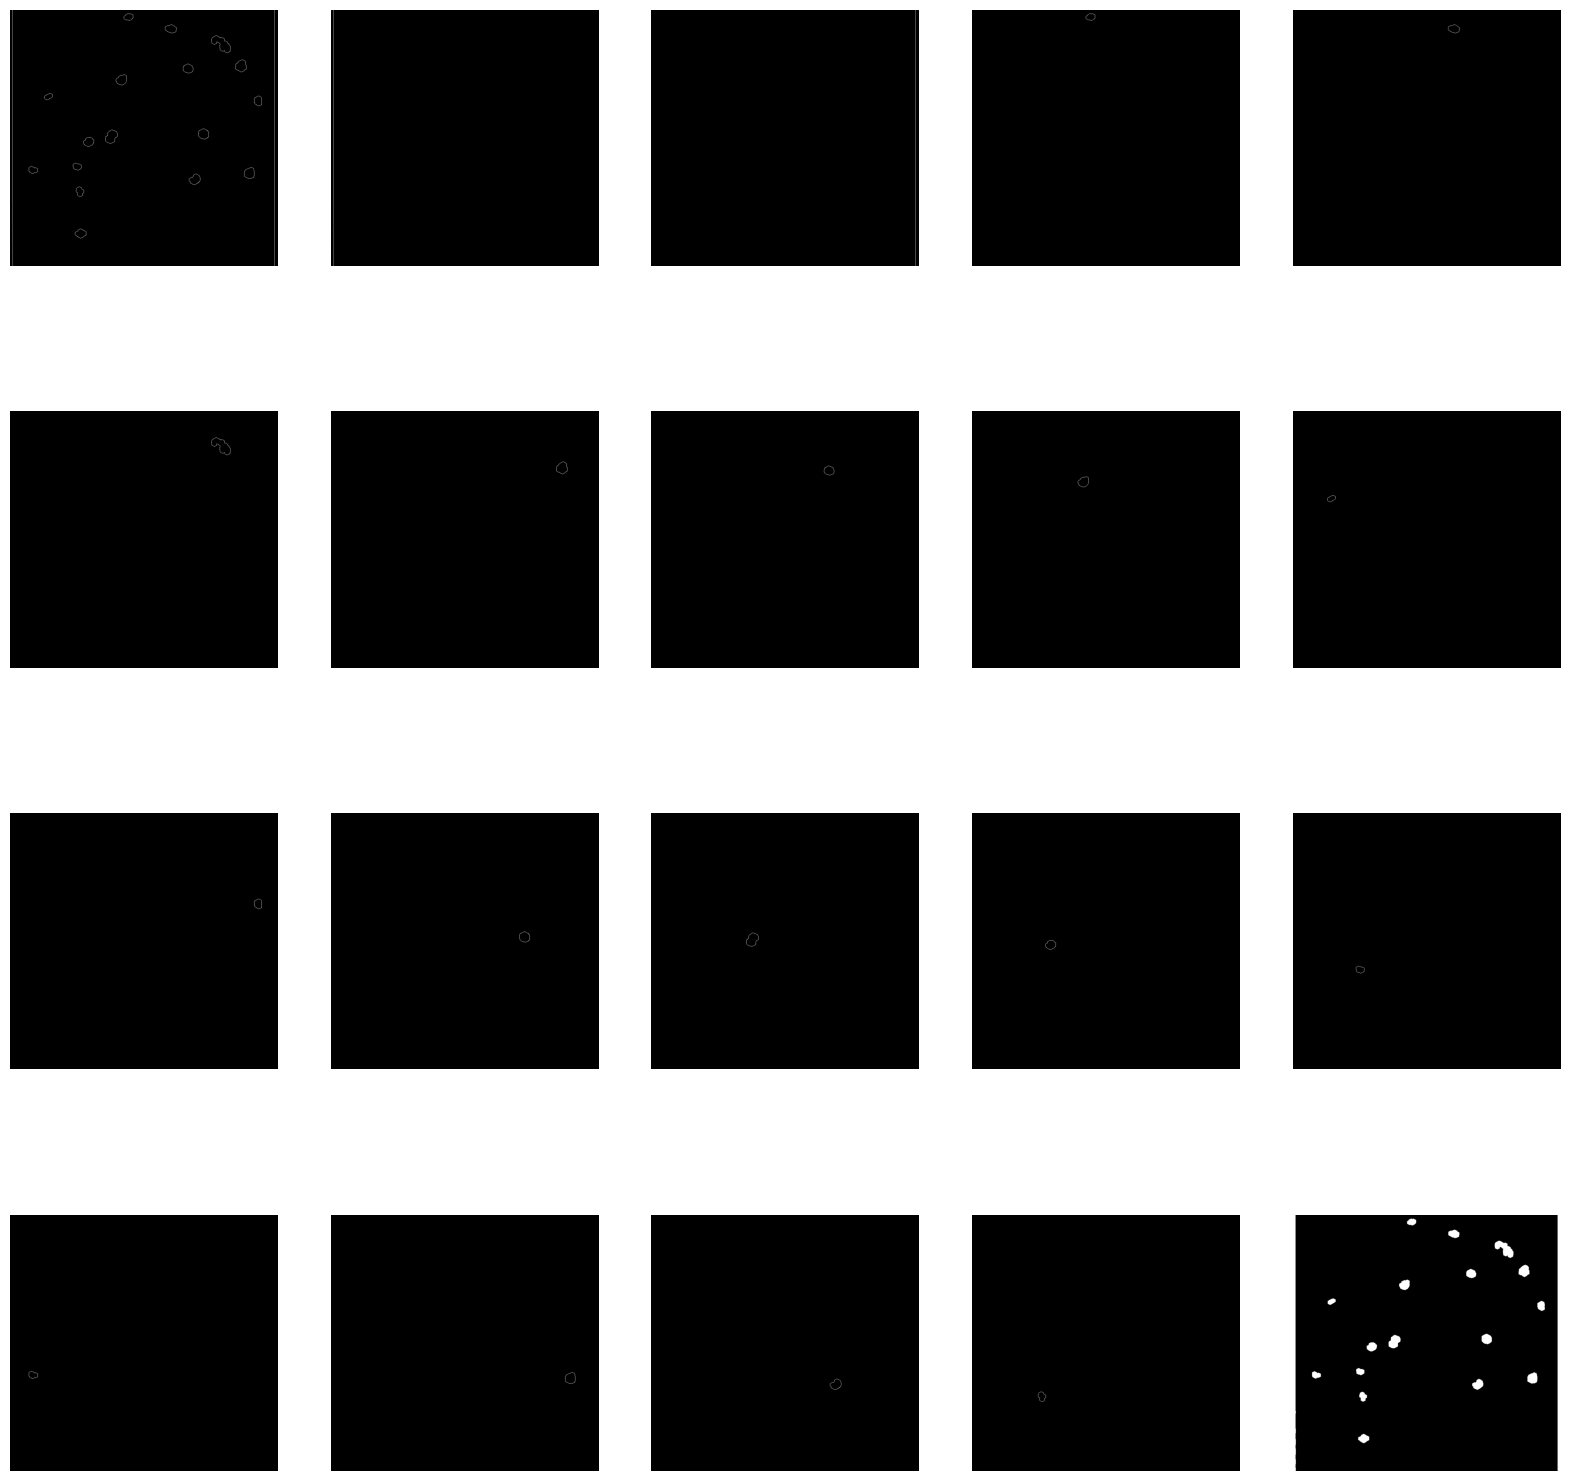

In [89]:
rows = 4
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

print("len ccl_edges: ", len(ccl_edges))
ccl_edges.append(morf_img)

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(edges):
            axes[i, j].imshow(ccl_edges[index], cmap='gray') 
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.show()